In [ ]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00


In [ ]:
import nltk
import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import brown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn_crfsuite import CRF  # If using CRFSuite for implementation
from sklearn.metrics import fbeta_score, accuracy_score, classification_report

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')

# Load the Brown corpus with the universal tagset
brown_sents = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]

def sent2tokens(sent):
    return [token for token, _ in sent]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn_crfsuite import CRF  # Keep CRF from sklearn-crfsuite

# Assuming you have already defined sent2features and sent2labels

kf = KFold(n_splits=5)

X = [sent2features(s) for s in brown_sents]
y = [sent2labels(s) for s in brown_sents]

# Perform 5-fold cross-validation
accuracies = []
all_precision = []
all_recall = []
all_f1 = []
all_f2 = []
all_f0_5 = []
all_true_tags = []
all_predicted_tags = []

for train_index, test_index in kf.split(brown_sents):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
    crf.fit(X_train, y_train)

    y_pred = crf.predict(X_test)

    # Flatten the true and predicted labels
    y_test_flat = [label for sent in y_test for label in sent]
    y_pred_flat = [label for sent in y_pred for label in sent]

    # Print accuracy and classification report
    print("Accuracy: ", accuracy_score(y_test_flat, y_pred_flat))
    print(classification_report(y_test_flat, y_pred_flat, digits=3))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_flat, y_pred_flat, average=None, labels=sorted(set(y_test_flat)))

    # Accumulate true and predicted tags for confusion matrix
    all_true_tags.extend(y_test_flat)
    all_predicted_tags.extend(y_pred_flat)

    # Calculate F2 score
    f2_score = fbeta_score(y_test_flat, y_pred_flat, beta=2, average='macro')
    print("F2 Score (Macro):", f2_score)

    # Calculate F0.5 score
    f05_score = fbeta_score(y_test_flat, y_pred_flat, beta=0.5, average='macro')
    print("F0.5 Score (Macro):", f05_score)

    # Accumulate scores
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_f2.append(f2_score)
    all_f0_5.append(f05_score)
    accuracies.append(accuracy_score(y_test_flat, y_pred_flat))

Accuracy:  0.9735540821217447
              precision    recall  f1-score   support

           .      1.000     1.000     1.000     30115
         ADJ      0.928     0.907     0.918     18941
         ADP      0.980     0.985     0.982     31048
         ADV      0.941     0.938     0.940     10971
        CONJ      0.993     0.997     0.995      7662
         DET      0.995     0.996     0.996     29455
        NOUN      0.968     0.973     0.971     66790
         NUM      0.983     0.950     0.966      3974
        PRON      0.990     0.990     0.990      8204
         PRT      0.943     0.936     0.939      5791
        VERB      0.969     0.974     0.972     37128
           X      0.654     0.431     0.519       281

    accuracy                          0.974    250360
   macro avg      0.945     0.923     0.932    250360
weighted avg      0.973     0.974     0.973    250360

F2 Score (Macro): 0.9264080716890916
F0.5 Score (Macro): 0.9394842708480704
Accuracy:  0.97277625218801

In [ ]:
import pandas as pd
# Calculate average precision, recall, F1-score
avg_precision = np.mean(all_precision, axis=0)
avg_recall = np.mean(all_recall, axis=0)
avg_f1 = np.mean(all_f1, axis=0)
avg_accuracy = np.mean(accuracies)
avg_f2 = np.mean(all_f2)
avg_f0_5 = np.mean(all_f0_5)

labels = sorted(set(all_true_tags))  # Get all unique tags
conf_matrix = confusion_matrix(all_true_tags, all_predicted_tags, labels=labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
per_pos_accuracy = {}
for i, tag in enumerate(labels):
    true_positives = conf_matrix[i, i]
    total_relevant = np.sum(conf_matrix[i, :])
    per_pos_accuracy[tag] = true_positives / total_relevant if total_relevant > 0 else 0

# Print average scores
print("Per-POS Accuracy:\n", per_pos_accuracy)
print("\nAverage Precision per POS tag:\n", dict(zip(conf_matrix_df.index, avg_precision)))
print("\nAverage Recall per POS tag:\n", dict(zip(conf_matrix_df.index, avg_recall)))
print("\nAverage F1-Score per POS tag:\n", dict(zip(conf_matrix_df.index, avg_f1)))
print("Average Precision:", np.mean(avg_precision))
print("Average Recall:", np.mean(avg_recall))
print("Average Accuracy:", np.mean(avg_accuracy))
print("Average F1-score:", np.mean(avg_f1))
print("Average F2 Score:", avg_f2)
print("Average F0.5 Score:", avg_f0_5)

overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
    all_true_tags, all_predicted_tags, average='macro'
)

# Calculate F2 score (beta=2) and F0.5 score (beta=0.5)
_, _, f2_score, _ = precision_recall_fscore_support(
    all_true_tags, all_predicted_tags, average='macro', beta=2
)

_, _, f0_5_score, _ = precision_recall_fscore_support(
    all_true_tags, all_predicted_tags, average='macro', beta=0.5
)

Per-POS Accuracy:
 {'.': 0.999925456578457, 'ADJ': 0.9141553493149867, 'ADP': 0.9822886589392537, 'ADV': 0.9309731680862036, 'CONJ': 0.9966449110115069, 'DET': 0.9946649734708325, 'NOUN': 0.9749090935483636, 'NUM': 0.955089417775985, 'PRON': 0.9873109822840231, 'PRT': 0.9386167823259244, 'VERB': 0.9761039671682626, 'X': 0.3593073593073593}

Average Precision per POS tag:
 {'.': 0.9996858042093457, 'ADJ': 0.9285849316819661, 'ADP': 0.9764674465845854, 'ADV': 0.9447878033701951, 'CONJ': 0.9937897240167295, 'DET': 0.9935681594620837, 'NOUN': 0.9663366426169808, 'NUM': 0.9681854341848348, 'PRON': 0.9920284680502943, 'PRT': 0.9428908091132939, 'VERB': 0.9739102099692516, 'X': 0.6831835128202332}

Average Recall per POS tag:
 {'.': 0.9999273375668715, 'ADJ': 0.9118343237013686, 'ADP': 0.981647290180196, 'ADV': 0.9308848042833147, 'CONJ': 0.99658584910815, 'DET': 0.9941323248144476, 'NOUN': 0.9747607595489963, 'NUM': 0.9606530988375832, 'PRON': 0.9873220628833016, 'PRT': 0.9392486872372571, '

In [ ]:
print(f"Overall F1-Score: {overall_f1:.4f}")
print(f"Overall F2-Score: {f2_score:.4f}")
print(f"Overall F0.5-Score: {f0_5_score:.4f}")
print(f"Overall precison: {overall_precision:.4f}")

Overall F1-Score: 0.9291
Overall F2-Score: 0.9215
Overall F0.5-Score: 0.9398
Overall precison: 0.9501


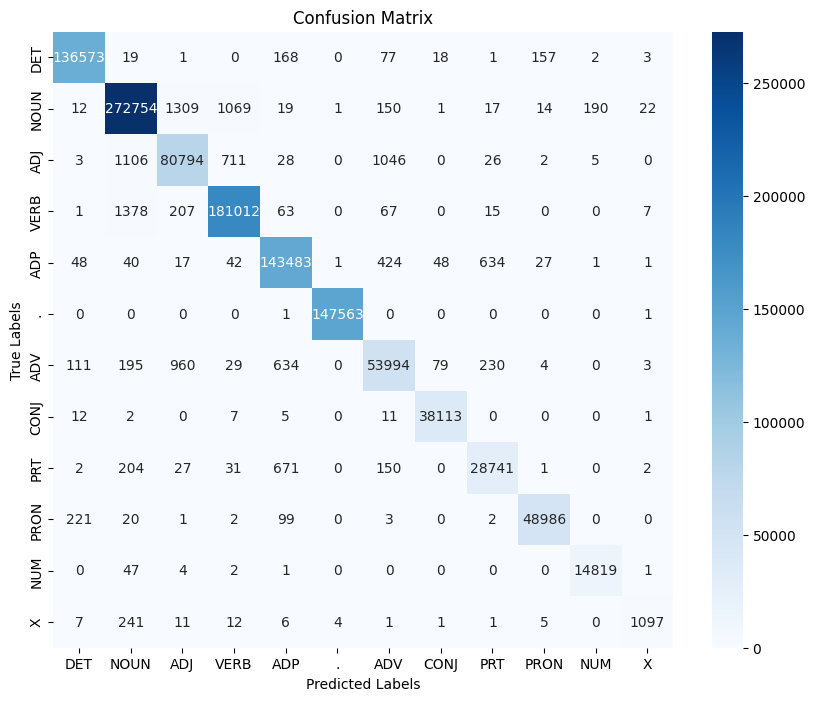

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix([item for sublist in y_true for item in sublist],
                          [item for sublist in y_pred for item in sublist], labels=labels)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()

labels = list(crf.classes_)
y_true = [sent2labels(s) for s in brown_sents]
y_pred = crf.predict(X)

plot_confusion_matrix(y_true, y_pred, labels)


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def tag_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    sent = [(token, '') for token in tokens]  # Dummy tags, not used in features
    features = [word2features(sent, i) for i in range(len(sent))]
    tags = crf.predict([features])[0]
    return list(zip(tokens, tags))

# Example
sentence = "The quick brown fox jumps over the lazy dog."
tagged_sentence = tag_sentence(sentence)
print(tagged_sentence)

[('The', 'DET'), ('quick', 'ADJ'), ('brown', 'NOUN'), ('fox', 'NOUN'), ('jumps', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('lazy', 'ADJ'), ('dog', 'NOUN'), ('.', '.')]


In [ ]:
!pip install gradio
import gradio as gr
import nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.7 MB/s eta 0:00:00


In [ ]:
# Create Gradio interface
def crf_pos_tagging(input_sentence):
    tagged_sentence = tag_sentence(input_sentence)
    return tagged_sentence

In [ ]:
# Set up Gradio interface
interface = gr.Interface(
    fn=crf_pos_tagging,                # Function to use
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence here"),  # Input type
    outputs="json",                    # Output in JSON format
    title="CRF POS Tagging",           # Title of the app
    description="Enter a sentence and get POS tags using a CRF model."  # Description
)

# Launch the interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d408b311de5d48ecf5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
